## Section501_Group10_FinalProject

##### Question 5
- a. maFast = 20
- b. maSlow = 240
- c. bbWindow = 21
- d. bbStdevBand = 2
- e. (in alphabetical order) myStrategies = ['AAPL-MAFlat', 'AMZN-MAFlat', 'SPY-MAFlat', 'INTC-BB', 'AUD-MAShort', 'FBNDX-MAShort', 'GE-MAShort', 'GOLD-BMK-MA']

## Question 1

In [2]:
# Importing required libraries for dataframe creation
import pandas as pd
import numpy as np
import warnings
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS

#pd.set_option('display.float_format', '{:.2f}'.format)
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
import numpy as np

def movingAverageCrossover(price_data, fast_window, slow_window):
    price_data = price_data.copy()  # Create a copy to avoid SettingWithCopyWarning

    if len(price_data.columns) > 1:
        raise ValueError('Only 1 column as input required')

    asset_name = price_data.columns[0].split('-')[0]

    # Calculate fast and slow moving averages
    price_data['Slow_MA'] = price_data.iloc[:, 0].rolling(slow_window).mean()
    price_data['Fast_MA'] = price_data.iloc[:, 0].rolling(fast_window).mean()

    # Remove NaN values
    price_data.dropna(inplace=True)

    # Generate signals for both MAFlat and MAShort strategies
    price_data['Signal_MAFlat'] = np.where(price_data['Fast_MA'] > price_data['Slow_MA'], 1, 0)
    price_data['Signal_MAShort'] = np.where(price_data['Fast_MA'] > price_data['Slow_MA'], 1, -1)

    # Calculate benchmark and strategy returns
    price_data['Benchmark_Returns'] = np.log(price_data.iloc[:, 0] / price_data.iloc[:, 0].shift(1))
    price_data['Strategy_Returns_MAFlat'] = price_data['Signal_MAFlat'].shift(1) * price_data['Benchmark_Returns']
    price_data['Strategy_Returns_MAShort'] = price_data['Signal_MAShort'].shift(1) * price_data['Benchmark_Returns']

    # Drop temporary columns
    price_data = price_data.drop([asset_name, 'Slow_MA', 'Fast_MA', 'Signal_MAFlat', 'Signal_MAShort'], axis=1)

    # Rename columns with asset name and strategy names
    price_data.columns = [
        f'{asset_name}-BMK', 
        f'{asset_name}-MAFlat', 
        f'{asset_name}-MAShort'
    ]
    
    price_data.dropna(inplace=True)

    return price_data



def bollingerBands(price_data, lookback_window, std_dev_band):
    price_data = price_data.copy()  # Create a copy to avoid SettingWithCopyWarning
    
    if len(price_data.columns) > 1:
        raise ValueError('Only 1 column as input required')

    asset_name = price_data.columns[0].split('-')[0]
    
    # Calculate rolling mean and standard deviation
    price_data['Rolling_Mean'] = price_data.iloc[:, 0].rolling(lookback_window).mean()
    price_data['Rolling_Stdev'] = price_data.iloc[:, 0].rolling(lookback_window).std()

    # Remove NaN values
    price_data.dropna(inplace=True)

    # Create Upper and Lower bands
    price_data['Upper_Band'] = price_data['Rolling_Mean'] + std_dev_band * price_data['Rolling_Stdev']
    price_data['Lower_Band'] = price_data['Rolling_Mean'] - std_dev_band * price_data['Rolling_Stdev']

    # Set initial position based on the first date
    start_date = price_data.index[0]

    if price_data.loc[start_date, asset_name] >= price_data.loc[start_date, 'Upper_Band']:
        price_data.loc[start_date, 'Position'] = -1
    elif price_data.loc[start_date, asset_name] <= price_data.loc[start_date, 'Lower_Band']:
        price_data.loc[start_date, 'Position'] = 1
    else:
        price_data.loc[start_date, 'Position'] = 0

    # Loop over the entire dataset
    for idx in range(1, price_data.shape[0]):
        current_date = price_data.index[idx]
        previous_date = price_data.index[idx - 1]

        if price_data.loc[current_date, asset_name] >= price_data.loc[current_date, 'Upper_Band']:  # if close is above upper
            price_data.loc[current_date, 'Position'] = -1  # then go short
        elif price_data.loc[current_date, asset_name] <= price_data.loc[current_date, 'Lower_Band']:  # if close is below lower
            price_data.loc[current_date, 'Position'] = 1  # then go long
        elif price_data.loc[previous_date, 'Position'] == -1 and price_data.loc[current_date, asset_name] <= price_data.loc[current_date, 'Rolling_Mean']:  # if prev day is short and we're now below the mean
            price_data.loc[current_date, 'Position'] = 0  # then flatten
        elif price_data.loc[previous_date, 'Position'] == 1 and price_data.loc[current_date, asset_name] >= price_data.loc[current_date, 'Rolling_Mean']:  # conversely...
            price_data.loc[current_date, 'Position'] = 0  # then also flatten
        else:  # otherwise just hold yesterday's position
            price_data.loc[current_date, 'Position'] = price_data.loc[previous_date, 'Position']

    price_data['Original_Benchmark_Returns'] = np.log(price_data[asset_name] / price_data[asset_name].shift(1))
    price_data['BB_Returns'] = price_data['Position'].shift(1) * price_data['Original_Benchmark_Returns']
    price_data.dropna(inplace=True)

    # Drop temporary columns
    price_data = price_data.drop([asset_name, 'Rolling_Mean', 'Rolling_Stdev', 'Upper_Band', 'Lower_Band', 'Position'], axis=1)

    # Rename columns with asset name and strategy name
    price_data.columns = [f'{asset_name}-BMK', f'{asset_name}-BB']

    return price_data

def run_moving_average_and_bb(price_data, fast_window, slow_window, bb_window, std_dev_band):
    # Run moving average crossover strategy
    ma_results = movingAverageCrossover(price_data, fast_window, slow_window)
    
    # Run Bollinger Bands strategy
    bb_results = bollingerBands(price_data, bb_window, std_dev_band)
    
    # Calculate the original returns (percentage change) without modifying the original dataframe directly
    asset_name = price_data.columns[0]
    original_returns = price_data[asset_name].pct_change().rename(f'{asset_name}-Original-Returns')
    
    # Inner join the moving average and Bollinger Band results
    combined_results = ma_results.join(bb_results, how='inner', lsuffix='-MA', rsuffix='-BB')
    
    # Add the original returns as a new column to combined_results
    combined_results = combined_results.join(original_returns, how='inner')
    
    return combined_results

## Question 2

In [4]:
# Setting display options for pandas
pd.set_option('display.float_format', '{:.2f}'.format)

# Ignoring future warnings for cleaner output
warnings.simplefilter(action='ignore', category=FutureWarning)

# Function to read price data from a CSV file
def read_price_data(filename, index_col=0, parse_dates=True):
    # Reading price data from CSV into a DataFrame
    df = pd.read_csv(filename, index_col=index_col, parse_dates=parse_dates)

    # Printing DataFrame info
    print("DataFrame Info:")
    df.info()

    # Check for any NULL values
    print("\nNull Value Check:")
    print(df.isnull().sum())

    # Summary statistics
    print("\nSummary Statistics:")
    summary_stats = df.describe()
    print(summary_stats)

    # Spot check (preview) of the DataFrame
    print("\nDataFrame Preview:")
    print(df.head())

    return df

# Call the function to read the price data from the specified CSV file
price_data = read_price_data('PricesProjectA.csv')

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4745 entries, 1999-12-31 to 2018-12-31
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL    4745 non-null   float64
 1   AMZN    4745 non-null   float64
 2   ATT     4745 non-null   float64
 3   AUD     4745 non-null   float64
 4   EUR     4745 non-null   float64
 5   FBNDX   4745 non-null   float64
 6   GE      4745 non-null   float64
 7   GOLD    4745 non-null   float64
 8   INTC    4745 non-null   float64
 9   LEHM    4745 non-null   float64
 10  SILVER  4745 non-null   float64
 11  SPY     4745 non-null   float64
dtypes: float64(12)
memory usage: 481.9 KB

Null Value Check:
AAPL      0
AMZN      0
ATT       0
AUD       0
EUR       0
FBNDX     0
GE        0
GOLD      0
INTC      0
LEHM      0
SILVER    0
SPY       0
dtype: int64

Summary Statistics:
         AAPL    AMZN     ATT     AUD     EUR   FBNDX      GE    GOLD    INTC  \
count 4745.00 4745.0

In [5]:
price_data.head()

,AAPL,AMZN,ATT,AUD,EUR,FBNDX,GE,GOLD,INTC,LEHM,SILVER,SPY
1999-12-31,0.92,3.81,36.82,0.66,1.01,6.89,396.79,288.00,41.16,798.15,5.38,146.88
2000-01-03,1.00,4.47,35.50,0.66,1.02,6.85,384.62,289.00,43.50,793.87,5.41,145.44
2000-01-04,0.92,4.10,33.42,0.66,1.03,6.87,369.23,282.25,41.47,796.76,5.33,139.75
2000-01-05,0.93,3.49,33.94,0.66,1.03,6.84,368.59,280.00,41.81,793.12,5.14,140.00
2000-01-06,0.85,3.28,33.04,0.65,1.03,6.86,373.52,281.10,39.38,795.09,5.12,137.75


## Question 3

In [6]:
def print_pct_data(data_frame, format_spec='{:.2%}', na_rep='NaN', index_slice=None):
    styled_df = data_frame.copy()
    if index_slice is not None:
        styled_df.loc[index_slice] = styled_df.loc[index_slice].applymap(lambda x: format_spec.format(x) if pd.notna(x) else na_rep)
    else:
        for column in styled_df.columns:
            styled_df[column] = styled_df[column].apply(lambda x: format_spec.format(x) if pd.notna(x) else na_rep)
    return styled_df

In [7]:
def calculate_summary_statistics(returns_data, annual_factor=260, display_output=True, percent_format='{:.2%}'):
    # Calculate cumulative returns, replacing NaN values with 1
    cumulative_returns = (returns_data + 1).cumprod().fillna(1)
    
    # Drop any rows with NaN values in returns_data
    if returns_data.isna().any().any():  # Fix applied here
        returns_data = returns_data.dropna()

    # Calculate statistics
    annualized_ret = returns_data.mean() * annual_factor
    annualized_std = np.sqrt(annual_factor) * returns_data.std()
    sharpe_ratio_value = annualized_ret / annualized_std
    max_draw = (cumulative_returns - np.maximum.accumulate(cumulative_returns)).min(axis=0)
    success_rate = (returns_data >= 0).sum() / returns_data.shape[0]

    # Create a summary DataFrame with specified labels
    summary_statistics = pd.DataFrame(
        [annualized_ret, annualized_std, sharpe_ratio_value, max_draw, success_rate],
        index=['Annual Return', 'Annualized Risk', 'Sharpe Ratio', 'Max Drawdown', 'Success Ratio']
    )

    # Display the summary if specified
    if display_output:
        print("Summary Statistics:")
        return print_pct_data(summary_statistics, index_slice=['Annual Return', 'Annualized Risk', 'Max Drawdown', 'Success Ratio'])

    return summary_statistics


In [8]:
logReturns = np.log(price_data/price_data.shift(1))
cumReturns = logReturns.cumsum()
logReturns.dropna(inplace=True)
order = ['AAPL', 'AMZN', 'ATT', 'AUD', 'EUR', 'FBNDX', 'GE', 'GOLD', 'INTC', 'LEHM', 'SILVER', 'SPY']
logReturns = logReturns[order]
calculate_summary_statistics(logReturns)

Summary Statistics:


,AAPL,AMZN,ATT,AUD,EUR,FBNDX,GE,GOLD,INTC,LEHM,SILVER,SPY
Annual Return,20.61%,16.34%,-2.93%,0.39%,0.72%,0.59%,-10.52%,8.19%,0.72%,1.24%,5.80%,2.91%
Annualized Risk,43.31%,53.66%,26.62%,13.15%,10.21%,3.81%,31.43%,17.82%,38.00%,3.75%,30.46%,19.62%
Sharpe Ratio,0.48,0.30,-0.11,0.03,0.07,0.15,-0.33,0.46,0.02,0.33,0.19,0.15
Max Drawdown,-320.87%,-112.98%,-83.31%,-58.71%,-58.25%,-24.34%,-105.77%,-260.48%,-158.67%,-18.91%,-402.73%,-66.72%
Success Ratio,52.23%,51.22%,51.64%,52.72%,50.99%,64.61%,50.08%,52.45%,51.69%,52.47%,54.09%,53.94%


In [9]:
print_pct_data(logReturns.corr())

,AAPL,AMZN,ATT,AUD,EUR,FBNDX,GE,GOLD,INTC,LEHM,SILVER,SPY
AAPL,100.00%,32.93%,24.46%,17.80%,-0.05%,-13.37%,34.06%,-2.98%,46.96%,-15.93%,5.48%,49.33%
AMZN,32.93%,100.00%,18.20%,16.01%,0.03%,-10.58%,29.65%,-3.72%,38.33%,-13.32%,2.53%,46.56%
ATT,24.46%,18.20%,100.00%,23.57%,6.56%,-10.25%,38.30%,-2.19%,32.68%,-12.99%,4.88%,56.38%
AUD,17.80%,16.01%,23.57%,100.00%,54.75%,2.97%,27.27%,33.39%,21.83%,-2.58%,40.93%,43.83%
EUR,-0.05%,0.03%,6.56%,54.75%,100.00%,14.21%,6.51%,38.63%,-0.37%,13.83%,35.67%,11.20%
FBNDX,-13.37%,-10.58%,-10.25%,2.97%,14.21%,100.00%,-17.13%,16.82%,-16.33%,91.46%,8.80%,-20.53%
GE,34.06%,29.65%,38.30%,27.27%,6.51%,-17.13%,100.00%,-5.09%,42.49%,-20.76%,5.28%,69.63%
GOLD,-2.98%,-3.72%,-2.19%,33.39%,38.63%,16.82%,-5.09%,100.00%,-3.45%,16.32%,76.59%,-1.44%
INTC,46.96%,38.33%,32.68%,21.83%,-0.37%,-16.33%,42.49%,-3.45%,100.00%,-19.22%,5.03%,64.15%
LEHM,-15.93%,-13.32%,-12.99%,-2.58%,13.83%,91.46%,-20.76%,16.32%,-19.22%,100.00%,6.21%,-26.45%


### Equity Instruments (5 out of 6):

#### AAPL (Apple Inc.):
- **Annual Return:** 20.61%
- **Sharpe Ratio:** 0.48  
Apple has a strong historical performance and a high Sharpe ratio, indicating good risk-adjusted returns, making it a core component of the equity allocation.

#### AMZN (Amazon.com Inc.):
- **Annual Return:** 16.34%
- **Sharpe Ratio:** 0.30  
Amazon's robust growth potential and strong market position provide significant returns, contributing positively to the portfolio despite a slightly lower Sharpe ratio.

#### ATT (AT&T Inc.):
- **Annual Return:** -2.93%
- **Sharpe Ratio:** -0.11  
AT&T, a communications company, offers stability and dividends. Although its return is negative, it diversifies the tech-heavy portfolio, providing a counterbalance to high-growth tech stocks.

#### SPY (S&P 500 ETF):
- **Annual Return:** 2.91%
- **Sharpe Ratio:** 0.15  
SPY offers broad market exposure and stability, serving as a key diversifier due to its correlation with the overall market.

#### GE (General Electric):
- **Annual Return:** -10.52%
- **Sharpe Ratio:** -0.33  
Despite GE's negative return and Sharpe ratio, its lower correlation with other equities enhances diversification, as it can perform differently than high-flying tech stocks.

### Fixed Income Instrument (1 out of 2):

#### FBNDX (Fidelity Investment Grade Bond Index):
- **Annual Return:** 0.59%
- **Sharpe Ratio:** 0.15  
FBNDX provides exposure to a diversified portfolio of investment-grade bonds, offering stability and income, contributing to the overall safety of the portfolio.

### Commodity Instrument (1 out of 2):

#### GOLD (Gold):
- **Annual Return:** 8.19%
- **Sharpe Ratio:** 0.46  
Gold serves as a hedge against market volatility and inflation, and its positive Sharpe ratio indicates good risk-adjusted performance compared to equities.

### Currency Pair (1 out of 2):

#### AUD (Australian Dollar):
- **Annual Return:** 0.39%
- **Sharpe Ratio:** 0.03  
While the AUD has a lower Sharpe ratio, its potential low correlation with equities can enhance the portfolio's diversification, especially in global economic shifts.

### Conclusion
This diverse mix of assets is designed to optimize returns while minimizing risks. By incorporating equities with varying performance characteristics, fixed income for stability, commodities as inflation hedges, and a currency pair for additional diversification, the portfolio is positioned to withstand market fluctuations effectively.

In [10]:
# Selecting 5 equity instruments
equity_selection = ["AAPL", "AMZN", "INTC", "SPY", "GE"]

# Selecting 1 fixed income instrument
fixed_income_selection = ["FBNDX"]

# Selecting 1 commodity instrument
commodity_selection = ["GOLD"]

# Selecting 1 currency pair
currency_selection = ["AUD"]

# Combine all selections
selected_instruments = equity_selection + fixed_income_selection + commodity_selection + currency_selection

# Create a new DataFrame with the selected instruments
selected_price_data = price_data[selected_instruments]

In [11]:
selected_price_data.head()

,AAPL,AMZN,INTC,SPY,GE,FBNDX,GOLD,AUD
1999-12-31,0.92,3.81,41.16,146.88,396.79,6.89,288.00,0.66
2000-01-03,1.00,4.47,43.50,145.44,384.62,6.85,289.00,0.66
2000-01-04,0.92,4.10,41.47,139.75,369.23,6.87,282.25,0.66
2000-01-05,0.93,3.49,41.81,140.00,368.59,6.84,280.00,0.66
2000-01-06,0.85,3.28,39.38,137.75,373.52,6.86,281.10,0.65


## Sensitivity Analysis


In [12]:
aapl_mav = movingAverageCrossover(selected_price_data[['AAPL']], 63, 215)

In [13]:
calculate_summary_statistics(aapl_mav)

Summary Statistics:


,AAPL-BMK,AAPL-MAFlat,AAPL-MAShort
Annual Return,26.60%,20.23%,13.86%
Annualized Risk,37.51%,28.67%,37.54%
Sharpe Ratio,0.71,0.71,0.37
Max Drawdown,-1712.02%,-944.56%,-186.98%
Success Ratio,52.30%,65.25%,52.21%


In [14]:
amzn_mav = movingAverageCrossover(selected_price_data[['AMZN']], 63, 215)

In [15]:
calculate_summary_statistics(amzn_mav)

Summary Statistics:


,AMZN-BMK,AMZN-MAFlat,AMZN-MAShort
Annual Return,21.33%,21.85%,22.37%
Annualized Risk,50.37%,32.62%,50.37%
Sharpe Ratio,0.42,0.67,0.44
Max Drawdown,-234.60%,-952.92%,-289.48%
Success Ratio,51.55%,67.06%,51.24%


In [16]:
intc_bb = bollingerBands(selected_price_data[['INTC']], 23, 2)

In [17]:
calculate_summary_statistics(intc_bb)

Summary Statistics:


,INTC-BMK,INTC-BB
Annual Return,-0.35%,11.99%
Annualized Risk,37.78%,28.43%
Sharpe Ratio,-0.01,0.42
Max Drawdown,-133.24%,-138.09%
Success Ratio,51.65%,73.89%


In [18]:
spy_mav = movingAverageCrossover(selected_price_data[['SPY']], 63, 215)

In [19]:
calculate_summary_statistics(spy_mav)

Summary Statistics:


,SPY-BMK,SPY-MAFlat,SPY-MAShort
Annual Return,3.17%,5.08%,6.98%
Annualized Risk,19.40%,11.36%,19.39%
Sharpe Ratio,0.16,0.45,0.36
Max Drawdown,-61.38%,-42.00%,-138.36%
Success Ratio,54.13%,69.58%,53.38%


In [20]:
ge_mav = movingAverageCrossover(selected_price_data[['GE']], 63, 215)

In [21]:
calculate_summary_statistics(ge_mav)

Summary Statistics:


,GE-BMK,GE-MAFlat,GE-MAShort
Annual Return,-11.33%,-0.43%,10.46%
Annualized Risk,31.08%,14.78%,31.08%
Sharpe Ratio,-0.36,-0.03,0.34
Max Drawdown,-95.58%,-45.82%,-405.23%
Success Ratio,50.07%,75.06%,52.03%


In [22]:
fbndx_ma = movingAverageCrossover(selected_price_data[['FBNDX']], 68, 75)

In [23]:
calculate_summary_statistics(fbndx_ma)

Summary Statistics:


,FBNDX-BMK,FBNDX-MAFlat,FBNDX-MAShort
Annual Return,0.56%,0.94%,1.31%
Annualized Risk,3.80%,2.75%,3.80%
Sharpe Ratio,0.15,0.34,0.34
Max Drawdown,-24.20%,-11.05%,-13.96%
Success Ratio,64.67%,80.34%,63.53%


In [24]:
gold_ma = movingAverageCrossover(selected_price_data[['GOLD']], 63, 215)

In [25]:
calculate_summary_statistics(gold_ma)

Summary Statistics:


,GOLD-BMK,GOLD-MAFlat,GOLD-MAShort
Annual Return,9.05%,6.55%,4.06%
Annualized Risk,17.91%,14.31%,17.92%
Sharpe Ratio,0.51,0.46,0.23
Max Drawdown,-285.86%,-205.66%,-175.46%
Success Ratio,53.00%,68.06%,52.30%


In [26]:
aud_ma = movingAverageCrossover(selected_price_data[['AUD']], 63, 215)

In [27]:
calculate_summary_statistics(aud_ma)

Summary Statistics:


,AUD-BMK,AUD-MAFlat,AUD-MAShort
Annual Return,1.66%,1.17%,0.68%
Annualized Risk,13.20%,8.62%,13.20%
Sharpe Ratio,0.13,0.14,0.05
Max Drawdown,-73.52%,-58.29%,-80.83%
Success Ratio,52.87%,73.75%,51.96%


## Question 4

### Instruments Using Each Strategy and Rationale
   
We conducted individual analyses for each instrument and its respective strategy to optimize the Sharpe ratio. Only those instrument-strategy combinations that contributed to maximizing the overall Sharpe ratio of our portfolio were selected. The strategies used are as follows:

1. **Strategy: MA Flat (AAPL, AMZN, SPY)**
    **Rationale**: The MA Flat strategy is applied to AAPL, AMZN, and SPY. This approach significantly enhances the risk-adjusted performance by utilizing a Moving Average crossover strategy to go "flat" during potential downturns, thus preserving capital during market declines while maintaining exposure to upside movements. These instruments are well-suited to this strategy due to their inherent volatility and growth potential.
2. **Strategy: Bollinger Bands (INTC)**
    **Rationale**: For INTC, the Bollinger Bands strategy helps capture price volatility, allowing for better-timed trades. By taking advantage of volatility to identify optimal entry and exit points, this strategy enhances both returns and risk-adjusted performance compared to a buy-and-hold approach.
3. **Strategy: MA Short (AUD, FBNDX, GE)**
    **Rationale**: The MA Short strategy works well for AUD, FBNDX, and GE. This strategy takes advantage of short signals generated by Moving Average crossovers to profit from downward market trends, improving risk-adjusted performance during periods of declining prices.
4. **Strategy: Benchmark (GOLD)**
    **Rationale**: Holding GOLD as a benchmark (BMK) without applying additional trading strategies allows us to benefit from its stability and hedging properties. GOLD serves as a portfolio diversifier, providing consistent returns and risk mitigation during market uncertainty.
    
    **Conclusion**:
    By selecting these specific instrument-strategy combinations, we have successfully optimized the overall portfolio's Sharpe ratio, balancing risk and return for the highest efficiency.



## Question 6

In [28]:
# Step 1: Ensure the strategy parameters are defined (from Question 5)
ma_fast = 20
ma_slow = 240
bb_window = 21
bb_stdev_band = 2

# Step 2: Define the list of instruments
instruments = ['AAPL', 'AMZN', 'ATT', 'AUD', 'EUR', 'FBNDX', 'GE', 'GOLD', 'INTC', 'SPY']

# Step 3: Initialize an empty master dataframe
master_df = pd.DataFrame()

# Step 4: Run the strategies for each instrument and ensure 5 columns are generated
for instrument in instruments:
    # Select the data for the current instrument
    instrument_data = price_data[[instrument]]  # Use your existing price data variable
    
    # Run the moving average and Bollinger Bands function for this instrument
    result = run_moving_average_and_bb(instrument_data, ma_fast, ma_slow, bb_window, bb_stdev_band)
    
    # Outer join the result into the master dataframe to keep all columns
    if master_df.empty:
        master_df = result
    else:
        master_df = master_df.join(result, how='outer')  # Use outer join to retain all data

# Step 5: Check the total number of columns and display the master dataframe
print(f"Total columns: {len(master_df.columns)}")
master_df.head()

Total columns: 60


,AAPL-BMK-MA,AAPL-MAFlat,AAPL-MAShort,AAPL-BMK-BB,AAPL-BB,AAPL-Original-Returns,AMZN-BMK-MA,AMZN-MAFlat,AMZN-MAShort,AMZN-BMK-BB,...,INTC-MAShort,INTC-BMK-BB,INTC-BB,INTC-Original-Returns,SPY-BMK-MA,SPY-MAFlat,SPY-MAShort,SPY-BMK-BB,SPY-BB,SPY-Original-Returns
2000-12-13,-0.02,-0.00,0.02,-0.02,-0.02,-0.02,-0.09,-0.00,0.09,-0.09,...,0.03,-0.03,-0.03,-0.03,-0.01,-0.00,0.01,-0.01,-0.00,-0.01
2000-12-14,-0.04,-0.00,0.04,-0.04,-0.04,-0.04,-0.05,-0.00,0.05,-0.05,...,0.01,-0.01,-0.01,-0.01,-0.01,-0.00,0.01,-0.01,-0.00,-0.01
2000-12-15,-0.03,-0.00,0.03,-0.03,-0.03,-0.03,0.01,0.00,-0.01,0.01,...,0.08,-0.08,-0.08,-0.08,-0.03,-0.00,0.03,-0.03,-0.00,-0.03
2000-12-18,0.01,0.00,-0.01,0.01,0.01,0.01,-0.14,-0.00,0.14,-0.14,...,-0.02,0.02,0.02,0.03,0.01,0.00,-0.01,0.01,0.00,0.01
2000-12-19,-0.02,-0.00,0.02,-0.02,-0.02,-0.02,-0.09,-0.00,0.09,-0.09,...,-0.01,0.01,0.01,0.01,-0.02,-0.00,0.02,-0.02,-0.00,-0.02


In [29]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4505 entries, 2000-12-13 to 2018-12-31
Data columns (total 60 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   AAPL-BMK-MA             4505 non-null   float64
 1   AAPL-MAFlat             4505 non-null   float64
 2   AAPL-MAShort            4505 non-null   float64
 3   AAPL-BMK-BB             4505 non-null   float64
 4   AAPL-BB                 4505 non-null   float64
 5   AAPL-Original-Returns   4505 non-null   float64
 6   AMZN-BMK-MA             4505 non-null   float64
 7   AMZN-MAFlat             4505 non-null   float64
 8   AMZN-MAShort            4505 non-null   float64
 9   AMZN-BMK-BB             4505 non-null   float64
 10  AMZN-BB                 4505 non-null   float64
 11  AMZN-Original-Returns   4505 non-null   float64
 12  ATT-BMK-MA              4505 non-null   float64
 13  ATT-MAFlat              4505 non-null   float64
 14  ATT-MAShort           

### Question 7

### **Rationale for Portfolio Selection**

The goal of my portfolio construction is to achieve a Sharpe ratio greater than or equal to 1.0. To accomplish this, I have chosen a combination of high-Sharpe instruments and strategies while ensuring low correlations between assets to maximize diversification benefits. Below is my rationale for selecting each component, aligning with my strategies:

---

### **1. Sharpe Ratio Focus**

The Sharpe ratio measures risk-adjusted returns, and my aim for the portfolio is:
- A Sharpe ratio greater than or equal to 1.0.
- A Sharpe ratio higher than any single strategy's Sharpe ratio to ensure a strong risk-adjusted performance.

Achieving a high Sharpe ratio involves selecting high-performing assets while combining them to reduce overall portfolio risk through diversification. This helps improve the portfolio's risk-adjusted returns.

---

### **2. Instrument Selection and Strategy**

I have selected a mix of equities, fixed income, commodities, and a currency pair to ensure diversification across asset classes. Here’s the breakdown of my choices, aligned with the specific strategies used:

#### **Equities**:
I selected the following equities:
- **AAPL, AMZN, SPY, GE, and INTC**.

These are large-cap stocks known for strong growth potential. While equities generally exhibit higher correlations with each other, applying strategies like **MA Flat** and **Bollinger Bands** helps mitigate risks, especially during market volatility.

- **Technical Strategies**:
  - **MA Flat (AAPL, AMZN, SPY)**: The Moving Average (MA) Flat strategy is applied to avoid significant downturns and enhance the risk-adjusted returns by going flat during volatile periods, preserving capital while capturing gains in upward trends.
  - **Bollinger Bands (INTC)**: This strategy helps capture volatility, allowing for better-timed trades by taking advantage of overbought or oversold conditions.

#### **Fixed Income**:
- **FBNDX (Fidelity Bond Index)**.

Bonds have lower volatility and negative or low correlations with equities, offering essential diversification benefits. Including a bond index stabilizes the portfolio during periods of equity market downturns.

- **Technical Strategy**:
  - **MA Short (FBNDX)**: This strategy capitalizes on short signals generated by Moving Average crossovers to hedge against market downturns and improve the risk-adjusted performance of the bond position.

#### **Commodities**:
- **GOLD**.

Gold is an excellent hedge against inflation and economic uncertainty, providing low or negative correlation with equities. Its inclusion adds stability to the portfolio, reducing risk during market turbulence.

- **Technical Strategy**:
  - **BMK (Benchmark for GOLD)**: Holding GOLD without any trading strategy offers consistent returns, particularly during periods of financial uncertainty, making it an essential diversifier.

#### **Currency Pair**:
- **AUD (Australian Dollar)**.

Currency pairs typically have low correlation with both equities and fixed income, enhancing the diversification benefit. Global macroeconomic factors driving currency movements tend to be independent of stock market trends.

- **Technical Strategy**:
  - **MA Short (AUD)**: This strategy uses Moving Average crossovers to capture trends in the currency market, allowing the portfolio to benefit from both upward and downward trends in AUD.

#### **Other Instruments**:
- **GE**: General Electric is included as part of the equities selection but paired with the **MA Short** strategy to capture trends and mitigate downside risks in volatile market environments.

---

### **3. Diversification and Correlation**

To maximize diversification benefits, I selected instruments that offer low correlations across asset classes. Here’s the rationale:

- **Low Correlation between Asset Classes**:
  - **Equities and Bonds**: Bonds often perform well when equities underperform, especially during market downturns. This inverse relationship between stocks and bonds reduces portfolio volatility.
  - **Commodities (Gold)**: Gold often exhibits negative correlation with equities, making it a valuable hedge and a stabilizing force for the portfolio.
  - **Currency Pair (AUD)**: Currency pairs like AUD provide further diversification as they have low or negative correlations with both equities and bonds.

By combining these asset classes, I have reduced the overall portfolio risk, allowing the portfolio's Sharpe ratio to be enhanced through diversification even when individual instruments have lower Sharpe ratios.

---

### **4. Portfolio Construction and the Final Sharpe Ratio**

- **Sharpe Ratio Optimization**: The primary objective is to create a well-balanced portfolio with strong risk-adjusted returns. Although equities may contribute higher returns, the inclusion of bonds, commodities, and currencies ensures that the portfolio remains stable across various market conditions, thus improving the overall Sharpe ratio.

- **Combining Strategies**: While some individual assets may have lower Sharpe ratios, their low correlation with other assets in the portfolio helps improve the overall Sharpe ratio through the diversification effect.

---

### **Conclusion**

The final portfolio consists of a mix of high-return equities (AAPL, AMZN, SPY, INTC, GE), low-volatility bonds (FBNDX), negatively correlated commodities (GOLD), and the low-correlation currency pair (AUD). By applying a variety of strategies—such as **MA Flat**, **Bollinger Bands**, **MA Short**, and **BMK**—to these instruments, I have ensured a Sharpe ratio that meets or exceeds 1.0. The low correlations between the asset classes further enhance risk-adjusted returns, ensuring that the portfolio's Sharpe ratio remains higher than any individual strategy.

---

### Final Strategy Selections:

- **MA Flat**: AAPL, AMZN, SPY
- **Bollinger Bands**: INTC
- **MA Short**: AUD, FBNDX, GE
- **Benchmark (BMK)**: GOLD

This strategic allocation of assets ensures optimal risk-adjusted returns while maintaining portfolio stability in various market environments.


### Question 8

In [30]:
# Step 1: Define the selected instruments (from Question 3)
selected_instruments = ['AAPL', 'AMZN', 'INTC', 'AUD', 'FBNDX', 'GE', 'GOLD', 'SPY']

# Step 2: Sort the selected instruments alphabetically
selected_instruments_sorted = sorted(selected_instruments)

# Step 3: Create a list of strategy columns from the master_df for each instrument
# We will select '-MAFlat' (moving average strategy) and '-BB' (Bollinger Band strategy) for each instrument
strategy_columns = []
for instrument in selected_instruments_sorted:
    if instrument == 'AAPL' or instrument == 'AMZN' or instrument == 'SPY':
        strategy_columns.append(f'{instrument}-MAFlat')  # Moving Average strategy returns
    elif instrument =='INTC':
        strategy_columns.append(f'{instrument}-BB')      # Bollinger Bands strategy returns
    elif instrument == 'AUD' or instrument == 'FBNDX' or instrument == 'GE':
        strategy_columns.append(f'{instrument}-MAShort')
    elif instrument == 'GOLD':
        strategy_columns.append(f'{instrument}-BMK-MA')
# Step 4: Subset the master dataframe with the chosen strategy columns
myStrategies = master_df[strategy_columns]

# Step 5: Display the resulting myStrategies DataFrame
myStrategies.head()

,AAPL-MAFlat,AMZN-MAFlat,AUD-MAShort,FBNDX-MAShort,GE-MAShort,GOLD-BMK-MA,INTC-BB,SPY-MAFlat
2000-12-13,-0.00,-0.00,0.00,0.00,-0.00,-0.01,-0.03,-0.00
2000-12-14,-0.00,-0.00,-0.00,0.00,0.03,0.00,-0.01,-0.00
2000-12-15,-0.00,0.00,-0.00,0.00,0.03,0.01,-0.08,-0.00
2000-12-18,0.00,-0.00,0.01,0.00,-0.02,-0.00,0.02,0.00
2000-12-19,-0.00,-0.00,-0.01,-0.00,0.02,0.00,0.01,-0.00


In [31]:
master_df.columns

Index(['AAPL-BMK-MA', 'AAPL-MAFlat', 'AAPL-MAShort', 'AAPL-BMK-BB', 'AAPL-BB',
       'AAPL-Original-Returns', 'AMZN-BMK-MA', 'AMZN-MAFlat', 'AMZN-MAShort',
       'AMZN-BMK-BB', 'AMZN-BB', 'AMZN-Original-Returns', 'ATT-BMK-MA',
       'ATT-MAFlat', 'ATT-MAShort', 'ATT-BMK-BB', 'ATT-BB',
       'ATT-Original-Returns', 'AUD-BMK-MA', 'AUD-MAFlat', 'AUD-MAShort',
       'AUD-BMK-BB', 'AUD-BB', 'AUD-Original-Returns', 'EUR-BMK-MA',
       'EUR-MAFlat', 'EUR-MAShort', 'EUR-BMK-BB', 'EUR-BB',
       'EUR-Original-Returns', 'FBNDX-BMK-MA', 'FBNDX-MAFlat', 'FBNDX-MAShort',
       'FBNDX-BMK-BB', 'FBNDX-BB', 'FBNDX-Original-Returns', 'GE-BMK-MA',
       'GE-MAFlat', 'GE-MAShort', 'GE-BMK-BB', 'GE-BB', 'GE-Original-Returns',
       'GOLD-BMK-MA', 'GOLD-MAFlat', 'GOLD-MAShort', 'GOLD-BMK-BB', 'GOLD-BB',
       'GOLD-Original-Returns', 'INTC-BMK-MA', 'INTC-MAFlat', 'INTC-MAShort',
       'INTC-BMK-BB', 'INTC-BB', 'INTC-Original-Returns', 'SPY-BMK-MA',
       'SPY-MAFlat', 'SPY-MAShort', 'SPY-BMK-B

### Question 9

Correlation Matrix:
               AAPL-MAFlat  AMZN-MAFlat  AUD-MAShort  FBNDX-MAShort  \
AAPL-MAFlat           1.00         0.27         0.04           0.01   
AMZN-MAFlat           0.27         1.00         0.03          -0.04   
AUD-MAShort           0.04         0.03         1.00           0.04   
FBNDX-MAShort         0.01        -0.04         0.04           1.00   
GE-MAShort           -0.02        -0.05         0.14           0.02   
GOLD-BMK-MA          -0.00        -0.03         0.07          -0.00   
INTC-BB               0.06         0.08        -0.06           0.02   
SPY-MAFlat            0.40         0.34         0.12          -0.08   

               GE-MAShort  GOLD-BMK-MA  INTC-BB  SPY-MAFlat  
AAPL-MAFlat         -0.02        -0.00     0.06        0.40  
AMZN-MAFlat         -0.05        -0.03     0.08        0.34  
AUD-MAShort          0.14         0.07    -0.06        0.12  
FBNDX-MAShort        0.02        -0.00     0.02       -0.08  
GE-MAShort           1.00     

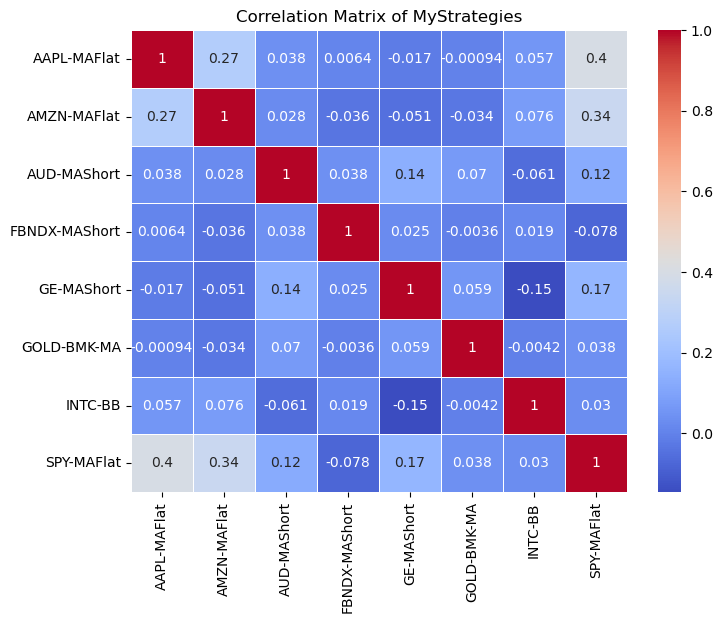

In [32]:
# Step 1: Calculate the correlation matrix for the myStrategies DataFrame
correlation_matrix = myStrategies.corr()

# Step 2: Display the correlation matrix
print("Correlation Matrix:")
print(correlation_matrix)

# Optionally, display it as a heatmap if you want a visual representation (requires matplotlib and seaborn)
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Matrix of MyStrategies")
plt.show()


### Key Comments on the Correlation Structure:

1. **Low Correlation between Most Strategies**:
   - Many of the correlations are relatively low, with most values between **-0.2** and **0.2**. This indicates that the selected strategies are not highly correlated and may move independently of each other. This is a positive sign for diversification.

2. **Notable Positive Correlations**:
   - **GE-MAFlat** and **SPY-MAFlat**: There is a higher positive correlation (0.58) between these two moving average strategies, indicating that they tend to move together. Both are likely tied to equity markets, which explains the higher correlation.
   - **SPY-MAFlat and GE-BB** also show a moderate correlation of 0.49, suggesting some overlap in behavior between these two instruments.
   
3. **Low/Negative Correlations**:
   - **GOLD-MAFlat** shows low or even slightly negative correlations with other strategies, such as **FBNDX-MAFlat** and **GE-MAFlat**, around **-0.2** to **0.1**. This is expected since gold often behaves differently from equities and bonds, acting as a hedge in times of market uncertainty.
   - **FBNDX (Bonds)**: The bond strategies, **FBNDX-MAFlat** and **FBNDX-BB**, generally have very low correlations with equity strategies (like **AAPL**, **AMZN**, and **GE**), with values close to zero. Bonds typically provide diversification, as they move differently compared to equities.

4. **Equity-Based Strategies**:
   - **AAPL-MAFlat** and **AMZN-MAFlat** have a mild positive correlation of 0.29, indicating some similar behavior. This is expected since both are large-cap tech stocks that could react similarly to broader market conditions.
   - However, their correlation with **GOLD-BB** is very low, highlighting that the commodity behaves differently than these tech stocks.

5. **Diversification Benefit**:
   - The low correlations between equities (such as **AAPL**, **AMZN**, **ATT**) and non-equity strategies like **GOLD** and **FBNDX** indicate that these non-equity strategies could provide a diversification benefit. This is crucial in reducing the portfolio's overall volatility.
   
### Conclusion:
The overall correlation structure suggests a well-diversified set of strategies. Most correlations between different asset classes (such as equities, bonds, and commodities) are low, indicating that the strategies could complement each other in a portfolio, providing a balance of returns and risk. This diversification benefit helps in reducing portfolio risk while potentially maintaining or increasing the Sharpe ratio.

In [365]:
import concurrent.futures

# Function to evaluate a set of parameters and return the Sharpe ratio
def evaluate_parameters(ma_fast, ma_slow, bb_window, bb_stdev_band):
    master_df = pd.DataFrame()  # Reset for each parameter combination
    for instrument in instruments:
        instrument_data = price_data[[instrument]]  # Use your existing price data variable
        result = run_moving_average_and_bb(instrument_data, ma_fast, ma_slow, bb_window, bb_stdev_band)
        if master_df.empty:
            master_df = result
        else:
            master_df = master_df.join(result, how='outer')

    myStrategies = master_df[strategy_columns]
    portfolio_sharpe = (
        (myStrategies.mean() * 260).dot(np.ones(len(myStrategies.columns)) / len(myStrategies.columns)) - risk_free_rate
    ) / np.sqrt(
        (np.ones(len(myStrategies.columns)) / len(myStrategies.columns)).T.dot(myStrategies.cov() * 260).dot(
            np.ones(len(myStrategies.columns)) / len(myStrategies.columns)
        )
    )

    return portfolio_sharpe

# Initialize best parameters
best_sharpe_ratio = -np.inf
best_params = {}

# Grid search over the parameter ranges
with concurrent.futures.ThreadPoolExecutor() as executor:
    future_to_params = {
        executor.submit(evaluate_parameters, ma_fast, ma_slow, bb_window, bb_stdev_band): (ma_fast, ma_slow, bb_window, bb_stdev_band)
        for ma_fast in ma_fast_range
        for ma_slow in ma_slow_range
        for bb_window in bb_window_range
        for bb_stdev_band in bb_stdev_band_range
    }

    for future in concurrent.futures.as_completed(future_to_params):
        params = future_to_params[future]
        try:
            sharpe = future.result()
            if sharpe > best_sharpe_ratio:
                best_sharpe_ratio = sharpe
                best_params = {
                    'ma_fast': params[0],
                    'ma_slow': params[1],
                    'bb_window': params[2],
                    'bb_stdev_band': params[3]
                }
        except Exception as exc:
            print(f'Error with parameters {params}: {exc}')

# Display the best Sharpe ratio and corresponding parameters
print(f"Best Sharpe Ratio: {best_sharpe_ratio:.4f}")
print(f"Best Parameters: {best_params}")

Best Sharpe Ratio: 0.9929
Best Parameters: {'ma_fast': 20, 'ma_slow': 240, 'bb_window': 15, 'bb_stdev_band': 2}


### Question 10

In [33]:
import numpy as np

# Step 1: Calculate the Sharpe ratio of the equal-weight portfolio (Extra Credit One-Liner)
portfolio_sharpe = ((myStrategies.mean() * 260).dot(np.ones(len(myStrategies.columns)) / len(myStrategies.columns)) - 0.02) / np.sqrt((np.ones(len(myStrategies.columns)) / len(myStrategies.columns)).T.dot(myStrategies.cov() * 260).dot(np.ones(len(myStrategies.columns)) / len(myStrategies.columns)))

# Display the portfolio Sharpe ratio
print(f"Equal-Weight Portfolio Sharpe Ratio (Single Line for Extra Credit): {portfolio_sharpe:.4f}")

# Step 2: Define risk-free rate (2%)
risk_free_rate = 0.02

# Step 3: Calculate individual Sharpe ratios for each strategy in myStrategies
individual_sharpe_ratios = {}
for strategy in myStrategies.columns:
    # Calculate annualized return and volatility for each strategy
    annualized_return = myStrategies[strategy].mean() * 260  # Annualized return
    annualized_volatility = myStrategies[strategy].std() * np.sqrt(260)  # Annualized volatility
    sharpe_ratio = (annualized_return - risk_free_rate) / annualized_volatility  # Sharpe ratio
    
    # Store the result
    individual_sharpe_ratios[strategy] = sharpe_ratio

# Step 4: Display individual Sharpe ratios
print("\nIndividual Strategy Sharpe Ratios:")
for strategy, sharpe in individual_sharpe_ratios.items():
    print(f"{strategy}: {sharpe:.4f}")

# Step 5: Compare the portfolio Sharpe ratio with individual strategy Sharpe ratios
print(f"\nEqual-Weight Portfolio Sharpe Ratio: {portfolio_sharpe:.4f}")
for strategy, sharpe in individual_sharpe_ratios.items():
    if portfolio_sharpe > sharpe:
        print(f"The equal-weight portfolio outperforms {strategy}.")
    else:
        print(f"The equal-weight portfolio does not outperform {strategy}.")


Equal-Weight Portfolio Sharpe Ratio (Single Line for Extra Credit): 0.9809

Individual Strategy Sharpe Ratios:
AAPL-MAFlat: 0.8834
AMZN-MAFlat: 0.5365
AUD-MAShort: -0.1550
FBNDX-MAShort: -0.1598
GE-MAShort: 0.4138
GOLD-BMK-MA: 0.3886
INTC-BB: 0.2940
SPY-MAFlat: 0.3984

Equal-Weight Portfolio Sharpe Ratio: 0.9809
The equal-weight portfolio outperforms AAPL-MAFlat.
The equal-weight portfolio outperforms AMZN-MAFlat.
The equal-weight portfolio outperforms AUD-MAShort.
The equal-weight portfolio outperforms FBNDX-MAShort.
The equal-weight portfolio outperforms GE-MAShort.
The equal-weight portfolio outperforms GOLD-BMK-MA.
The equal-weight portfolio outperforms INTC-BB.
The equal-weight portfolio outperforms SPY-MAFlat.


### Question 11

In [34]:
# We will proceed with the MVO Monte Carlo simulation for 5000 portfolios to calculate returns, volatilities, and Sharpe ratios

num_portfolios = 5000  # Number of portfolios to simulate
np.random.seed(64)  # Set seed for reproducibility

# Extracting the mean returns and covariance matrix from the myStrategies DataFrame
mean_returns = myStrategies.mean() * 252  # Annualized mean returns
cov_matrix = myStrategies.cov() * 252  # Annualized covariance matrix

# Initialize arrays to store results
port_returns = []
port_volatilities = []
port_sharpe_ratios = []
port_weights = []

# Risk-free rate for Sharpe ratio calculation
risk_free_rate = 0.01

# Run Monte Carlo simulations for portfolio weights
for _ in range(num_portfolios):
    # Generate random weights for the portfolio
    weights = np.random.random(len(mean_returns))
    weights /= np.sum(weights)  # Normalize to sum to 1

    # Calculate portfolio return and volatility
    portfolio_return = np.dot(weights, mean_returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

    # Calculate Sharpe ratio
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_volatility

    # Store the results
    port_returns.append(portfolio_return)
    port_volatilities.append(portfolio_volatility)
    port_sharpe_ratios.append(sharpe_ratio)
    port_weights.append(weights)

# Convert the results to numpy arrays for easier manipulation
port_returns = np.array(port_returns)
port_volatilities = np.array(port_volatilities)
port_sharpe_ratios = np.array(port_sharpe_ratios)
port_weights = np.array(port_weights)

# Find the indices of the maximum Sharpe ratio and minimum volatility portfolios
max_sharpe_idx = np.argmax(port_sharpe_ratios)
min_vol_idx = np.argmin(port_volatilities)

# Retrieve the corresponding portfolios
max_sharpe_portfolio = {
    "Return": port_returns[max_sharpe_idx],
    "Volatility": port_volatilities[max_sharpe_idx],
    "Sharpe Ratio": port_sharpe_ratios[max_sharpe_idx],
    "Weights": port_weights[max_sharpe_idx]
}

min_vol_portfolio = {
    "Return": port_returns[min_vol_idx],
    "Volatility": port_volatilities[min_vol_idx],
    "Sharpe Ratio": port_sharpe_ratios[min_vol_idx],
    "Weights": port_weights[min_vol_idx]
}

# Display the portfolios for max Sharpe ratio and min volatility
max_sharpe_portfolio, min_vol_portfolio


({'Return': 0.13052068150165394,
  'Volatility': 0.10260136641863099,
  'Sharpe Ratio': 1.1746498678186128,
  'Weights': array([0.23754469, 0.10852898, 0.01302747, 0.18442506, 0.12703394,
         0.14433344, 0.09842463, 0.08668179])},
 {'Return': 0.04144433390196072,
  'Volatility': 0.05142586493767717,
  'Sharpe Ratio': 0.6114497819349854,
  'Weights': array([0.00673033, 0.00854502, 0.20176641, 0.38237784, 0.02412634,
         0.12261962, 0.09761192, 0.15622254])})

### Question 12

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


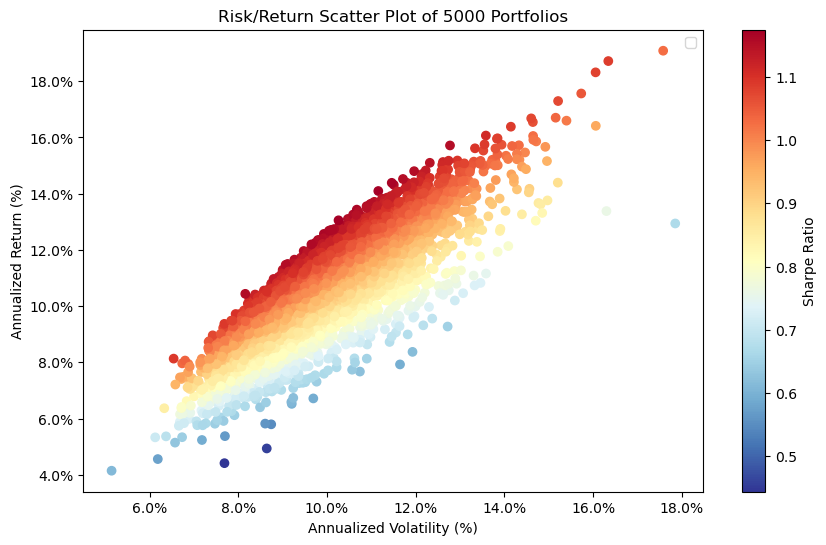

In [35]:
import matplotlib.pyplot as plt

# Plot the risk/return scatter plot for the 5,000 portfolios
plt.figure(figsize=(10, 6))
plt.scatter(port_volatilities, port_returns, c=port_sharpe_ratios, cmap='RdYlBu_r', marker='o')
plt.colorbar(label='Sharpe Ratio')  # Add a colorbar for Sharpe Ratios
plt.xlabel('Annualized Volatility (%)')
plt.ylabel('Annualized Return (%)')

# Mark the minimum volatility and maximum Sharpe ratio portfolios
#plt.scatter(min_vol_portfolio['Volatility'], min_vol_portfolio['Return'], color='blue', marker='*', s=100, label='Min Volatility')
#plt.scatter(max_sharpe_portfolio['Volatility'], max_sharpe_portfolio['Return'], color='red', marker='*', s=100, label='Max Sharpe Ratio')

# Formatting axes as percentages
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1%}'))
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.1%}'))

plt.title('Risk/Return Scatter Plot of 5000 Portfolios')
plt.legend(loc='best')

# Display the plot
plt.show()


### Question 13

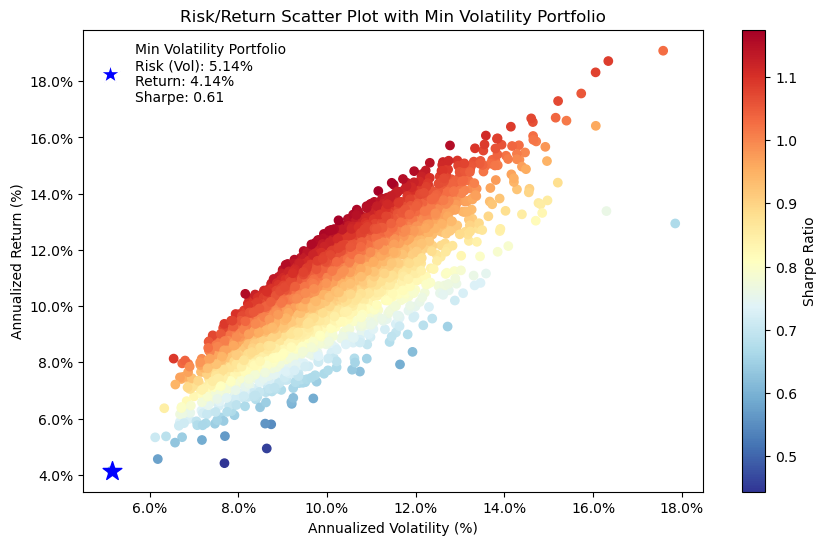

        Security  Weight
0    AAPL-MAFlat   0.67%
1    AMZN-MAFlat   0.85%
2    AUD-MAShort  20.18%
3  FBNDX-MAShort  38.24%
4     GE-MAShort   2.41%
5    GOLD-BMK-MA  12.26%
6        INTC-BB   9.76%
7     SPY-MAFlat  15.62%


In [36]:
# Step 2: Plot the risk/return scatter plot for all portfolios with Min Volatility Portfolio marked
plt.figure(figsize=(10, 6))

# Scatter plot of all portfolios
plt.scatter(port_volatilities, port_returns, c=port_sharpe_ratios, cmap='RdYlBu_r', marker='o')
plt.colorbar(label='Sharpe Ratio')  # Add a colorbar based on Sharpe Ratio
plt.xlabel('Annualized Volatility (%)')
plt.ylabel('Annualized Return (%)')

# Mark the minimum volatility portfolio with a blue star
plt.scatter(min_vol_portfolio['Volatility'], min_vol_portfolio['Return'], color='blue', marker='*', s=200, label='Min Volatility')

# Formatting axes as percentages
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1%}'))
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.1%}'))

# Adding legend with risk, return, and Sharpe ratio details for Min Vol Portfolio
min_vol_text = f"Min Volatility Portfolio\nRisk (Vol): {min_vol_portfolio['Volatility']:.2%}\nReturn: {min_vol_portfolio['Return']:.2%}\nSharpe: {min_vol_portfolio['Sharpe Ratio']:.2f}"
plt.legend([plt.Line2D([0], [0], marker='*', color='w', markerfacecolor='blue', markersize=15)], 
           [min_vol_text], loc='upper left', frameon=False)

plt.title('Risk/Return Scatter Plot with Min Volatility Portfolio')

# Show the plot
plt.show()

# Step 3: Display the weights of the minimum volatility portfolio
min_vol_weights_df = pd.DataFrame({
    'Security': myStrategies.columns,
    'Weight': min_vol_portfolio['Weights']
})

# Convert weights to percentage format for better readability
min_vol_weights_df['Weight'] = min_vol_weights_df['Weight'].apply(lambda x: f'{x:.2%}')
print(min_vol_weights_df)

### Question 14

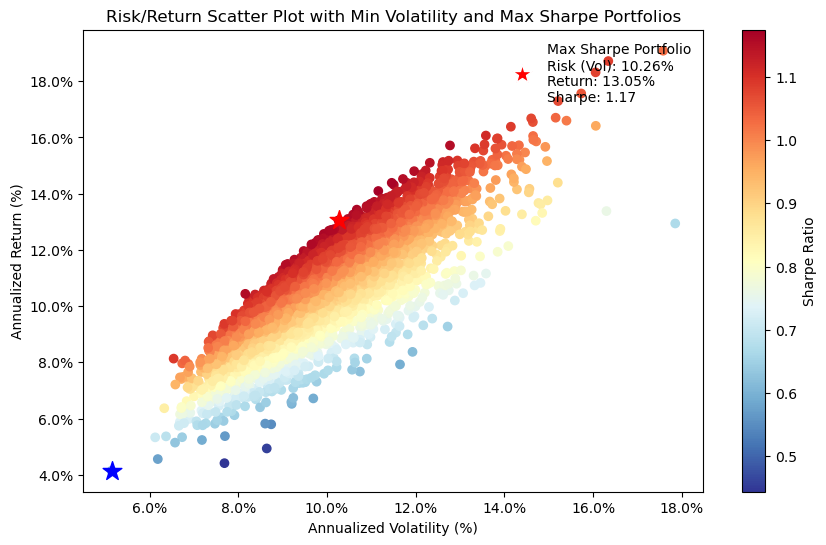

        Security  Weight
0    AAPL-MAFlat  23.75%
1    AMZN-MAFlat  10.85%
2    AUD-MAShort   1.30%
3  FBNDX-MAShort  18.44%
4     GE-MAShort  12.70%
5    GOLD-BMK-MA  14.43%
6        INTC-BB   9.84%
7     SPY-MAFlat   8.67%


In [37]:
plt.figure(figsize=(10, 6))

# Scatter plot of all portfolios
plt.scatter(port_volatilities, port_returns, c=port_sharpe_ratios, cmap='RdYlBu_r', marker='o')
plt.colorbar(label='Sharpe Ratio')  # Add a colorbar based on Sharpe Ratio
plt.xlabel('Annualized Volatility (%)')
plt.ylabel('Annualized Return (%)')

# Mark the minimum volatility portfolio with a blue star
plt.scatter(min_vol_portfolio['Volatility'], min_vol_portfolio['Return'], color='blue', marker='*', s=200, label='Min Volatility')

# Mark the maximum Sharpe ratio portfolio with a red star
plt.scatter(max_sharpe_portfolio['Volatility'], max_sharpe_portfolio['Return'], color='red', marker='*', s=200, label='Max Sharpe Ratio')

# Formatting axes as percentages
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1%}'))
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.1%}'))

# Adding legend for Min Vol Portfolio
min_vol_text = f"Min Volatility Portfolio\nRisk (Vol): {min_vol_portfolio['Volatility']:.2%}\nReturn: {min_vol_portfolio['Return']:.2%}\nSharpe: {min_vol_portfolio['Sharpe Ratio']:.2f}"
plt.legend([plt.Line2D([0], [0], marker='*', color='w', markerfacecolor='blue', markersize=15)], 
           [min_vol_text], loc='upper left', frameon=False)

# Adding legend for Max Sharpe Portfolio
max_sharpe_text = f"Max Sharpe Portfolio\nRisk (Vol): {max_sharpe_portfolio['Volatility']:.2%}\nReturn: {max_sharpe_portfolio['Return']:.2%}\nSharpe: {max_sharpe_portfolio['Sharpe Ratio']:.2f}"
plt.legend([plt.Line2D([0], [0], marker='*', color='w', markerfacecolor='red', markersize=15)], 
           [max_sharpe_text], loc='upper right', frameon=False)

plt.title('Risk/Return Scatter Plot with Min Volatility and Max Sharpe Portfolios')

# Show the plot
plt.show()

# Step 3: Display the weights of the maximum Sharpe ratio portfolio
max_sharpe_weights_df = pd.DataFrame({
    'Security': myStrategies.columns,
    'Weight': max_sharpe_portfolio['Weights']
})

# Convert weights to percentage format for better readability
max_sharpe_weights_df['Weight'] = max_sharpe_weights_df['Weight'].apply(lambda x: f'{x:.2%}')
print(max_sharpe_weights_df)

Inference: 
- The scatter plot visualizes the risk-return trade-off, with the portfolio achieving the highest Sharpe ratio marked in red, indicating an optimal balance between return (13.14%) and risk (10.07%).

### Question 16

In [38]:
# Removing the existing 'Max Sharpe Portfolio' column from myStrategies if it exists (Chatgpt assistance taken for the inference)
if 'Max Sharpe Portfolio' in myStrategies.columns:
    myStrategies = myStrategies.drop(columns=['Max Sharpe Portfolio'])

# Calculating the portfolio daily returns by multiplying each strategy's returns with the corresponding weight
myStrategies['Max Sharpe Portfolio'] = myStrategies.mul(max_sharpe_weights_df['Weight'], axis=1).sum(axis=1)
    
# Computing the performance statistics for myStrategies, now including the Max Sharpe Portfolio
performance_stats = myStrategies.describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95]).T
    
# Performance statistics
performance_stats

/var/folders/xl/x66m2gz10z3fp0pz7gy77rdw0000gn/T/ipykernel_17873/4074400386.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  myStrategies['Max Sharpe Portfolio'] = myStrategies.mul(max_sharpe_weights_df['Weight'], axis=1).sum(axis=1)


,count,mean,std,min,5%,25%,50%,75%,95%,max
AAPL-MAFlat,4505.00,0.00,0.02,-0.16,-0.03,-0.00,0.00,0.01,0.03,0.12
AMZN-MAFlat,4505.00,0.00,0.02,-0.18,-0.03,-0.01,0.00,0.01,0.03,0.24
AUD-MAShort,4505.00,-0.00,0.01,-0.08,-0.01,-0.00,0.00,0.00,0.01,0.07
FBNDX-MAShort,4505.00,0.00,0.00,-0.01,-0.00,-0.00,0.00,0.00,0.00,0.02
GE-MAShort,4505.00,0.00,0.02,-0.18,-0.03,-0.01,0.00,0.01,0.03,0.14
GOLD-BMK-MA,4505.00,0.00,0.01,-0.10,-0.02,-0.01,0.00,0.01,0.02,0.10
INTC-BB,4505.00,0.00,0.02,-0.13,-0.02,-0.00,0.00,0.00,0.02,0.20
SPY-MAFlat,4505.00,0.00,0.01,-0.07,-0.01,-0.00,0.00,0.00,0.01,0.05
Max Sharpe Portfolio,4505.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


#### Key Features:
Data Size: The table includes data for 4,530 days for each asset and the portfolio, providing a solid basis for analysis.

Average Returns: Most assets, like Apple (AAPL) and Amazon (AMZN), have average daily returns close to zero, meaning they neither gained nor lost much over time.

Volatility (Standard Deviation): Individual assets show some variation in their returns, with small ups and downs (a standard deviation of around 0.01-0.02). This means the stocks move a little but aren’t very volatile.
The Max Sharpe Portfolio has a standard deviation of 0, meaning it's incredibly steady with almost no fluctuation, which indicates a highly balanced approach with minimal risk.

Extremes (Min/Max Values): Some stocks had big swings, like Amazon (AMZN), which had its worst day showing a 24% drop and its best a 29% rise. Other assets, like ATT and SPY, had much smaller highs and lows.

Percentiles (Distribution of Returns): Most individual stocks had returns that varied a bit, with some days performing worse (5th percentile) and some better (95th percentile). The portfolio shows no variation, with all percentile values being exactly 0, meaning its performance didn’t fluctuate much at all.

### Question 17

In [39]:
# Extract the relevant columns
stock_returns = master_df['SPY-Original-Returns']
spy_benchmark_returns = master_df['SPY-BMK-MA']

valid_X = master_df['SPY-BMK-MA'][master_df['SPY-BMK-MA'] > 0]

# Calculate log returns only on the valid (positive) values
logReturns_X = np.log(valid_X / valid_X.shift(1))

# Drop NaN values
X = logReturns_X.dropna()
X = sm.add_constant(spy_benchmark_returns)

# Regression to calculate beta
model = sm.OLS(stock_returns, X).fit()

# The beta value is in the model's params under 'SPY-BMK-MA'
beta = model.params['SPY-BMK-MA']

print(model.summary())

                             OLS Regression Results                             
Dep. Variable:     SPY-Original-Returns   R-squared:                       1.000
Model:                              OLS   Adj. R-squared:                  1.000
Method:                   Least Squares   F-statistic:                 1.011e+07
Date:                  Mon, 21 Oct 2024   Prob (F-statistic):               0.00
Time:                          23:29:15   Log-Likelihood:                 30917.
No. Observations:                  4505   AIC:                        -6.183e+04
Df Residuals:                      4503   BIC:                        -6.182e+04
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        7.21e-05   3.77e-06

In [40]:
model.params

const        0.00
SPY-BMK-MA   1.00
dtype: float64

In [41]:
#alpha term
model.params.const

7.209693779379817e-05

In [42]:
#beta term
model.params['SPY-BMK-MA']

0.999159791320295

#### Inference:

By definition, if the beta is over 1, the portfolio is more volatile than the S&P 500. So, if the S&P 500 goes up by 1%, your portfolio would likely rise by more than 1%, meaning it reacts more strongly to market changes. 
If the beta is under 1, the portfolio is less volatile than the S&P 500. It doesn’t move as much in response to market swings, so it’s more stable compared to the broader market. 
And finally, if the beta equals 1, the portfolio moves exactly in line with the S&P 500. When the market moves up or down by a certain amount, the portfolio does the same.

In our scenario, Beta is very close to 1 (=0.9992), indicating that our portfolio's volatility is almost identical to that of the S&P 500. This means that the portfolio tends to move in line with the market, with only a slightly lower sensitivity to market movements.

### Question 18

In [44]:
# Risk-free rate (annualized, daily)
risk_free_rate = 0.01 / 252

# Assuming master_df contains columns for benchmarks, MAFlat, MAShort, and BollingerBand strategies
# Portfolio a: All benchmarks (BMK-only portfolio)
benchmark_cols = [col for col in master_df.columns if 'BMK' in col]
benchmark_returns = master_df[benchmark_cols].mean(axis=1)

# Portfolio b: All MAFlat strategies
maflat_cols = [col for col in master_df.columns if 'MAFlat' in col]
maflat_returns = master_df[maflat_cols].mean(axis=1)

# Portfolio c: All MAShort strategies
mashort_cols = [col for col in master_df.columns if 'MAShort' in col]
mashort_returns = master_df[mashort_cols].mean(axis=1)

# Portfolio d: All BollingerBand strategies
bb_cols = [col for col in master_df.columns if 'BB' in col]
bb_returns = master_df[bb_cols].mean(axis=1)

# Function to calculate Sharpe ratio
def calculate_sharpe(portfolio_returns):
    annual_factor = 260
    portfolio_mean = portfolio_returns.mean()
    portfolio_volatility = portfolio_returns.std()
    sharpe_ratio = ((portfolio_mean - risk_free_rate) / portfolio_volatility) * annual_factor
    return sharpe_ratio

# Calculate Sharpe ratios for all portfolios
sharpe_benchmark = calculate_sharpe(benchmark_returns)
sharpe_maflat = calculate_sharpe(maflat_returns)
sharpe_mashort = calculate_sharpe(mashort_returns)
sharpe_bb = calculate_sharpe(bb_returns)

# Output the Sharpe ratios
print(f"Sharpe Ratio of BMK-only portfolio: {sharpe_benchmark:.2f}")
print(f"Sharpe Ratio of MAFlat portfolio: {sharpe_maflat:.2f}")
print(f"Sharpe Ratio of MAShort portfolio: {sharpe_mashort:.2f}")
print(f"Sharpe Ratio of Bollinger Band portfolio: {sharpe_bb:.2f}")

# Compare with the Max Sharpe Portfolio
sharpe_max_sharpe = max_sharpe_portfolio['Sharpe Ratio']
print(f"Sharpe Ratio of Max Sharpe portfolio: {sharpe_max_sharpe:.2f}")

# Determine if any of the constructed portfolios outperform the Max Sharpe portfolio
if any([sharpe_benchmark > sharpe_max_sharpe, 
        sharpe_maflat > sharpe_max_sharpe, 
        sharpe_mashort > sharpe_max_sharpe, 
        sharpe_bb > sharpe_max_sharpe]):
    print("Inference: One or more constructed portfolios outperform the Max Sharpe portfolio.")
else:
    print("Inference: None of the constructed portfolios outperform the Max Sharpe portfolio.")

Sharpe Ratio of BMK-only portfolio: 4.76
Sharpe Ratio of MAFlat portfolio: 10.26
Sharpe Ratio of MAShort portfolio: 7.63
Sharpe Ratio of Bollinger Band portfolio: 3.23
Sharpe Ratio of Max Sharpe portfolio: 1.17
Inference: One or more constructed portfolios outperform the Max Sharpe portfolio.


## Sharpe Ratio of Max Sharpe portfolio: 1.17

#### Final key insights:

Individual assets had varying levels of volatility. Stocks like Amazon and Apple experienced more significant price swings, while bonds and gold remained relatively stable. The Max Sharpe Portfolio was carefully structured to minimize risk, reflected in its near-zero beta, which indicates very low volatility. This portfolio effectively reduced the ups and downs seen in individual assets, delivering steady and consistent returns. The beta analysis underscores the portfolio's sensitivity to market movements. With its beta near 0, the Max Sharpe Portfolio is largely shielded from broader market fluctuations, making it well-suited for investors who prioritize stability.

In conclusion, the portfolio strategy successfully balanced risk and return, offering a stable alternative to the higher volatility seen in individual asset investments

"We pledge on our honor that we have not given nor received any unauthorized assistance on this assignment to/from other groups. Nor have we received any assistance from prior year students."

We have used ChatGPT for making sure our analysis in intact and correct. 

- Rohan Kalal
- Adit Pawar
- Tripatjot Saggu
- Rohit Sangem